ใน ep นี้ เราจะมาเรียนรู้ งานจำแนกหมวดหมู่ข้อความ Text Classification ซึ่งเป็นงานพื้นฐานทางด้าน NLP ด้วยการทำ Latent Semantic Analysis (LSA) วิเคราะห์หาความหมายที่แฝงอยู่ในข้อความ โดยใช้เทคนิค Singular Value Decomposition (SVD) และ Non-negative Matrix Factorization (NMF)

# 1. Import

In [0]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn import decomposition
from scipy import linalg
import matplotlib.pyplot as plt

In [0]:
%matplotlib inline
np.set_printoptions(suppress=True)

# 2. Dataset

ในเคสนี้เราจะใช้ Dataset เป็นข้อความจาก Newsgroup 4 หมวดหมู่ คือ 

1. อเทวนิยม
1. ศาสนา 
1. คอมพิวเตอร์กราฟฟิก 
1. วิทยาศาสตร์ อวกาศ 

Newsgroup คือ ชุมชนออนไลน์ เหมือน Webboard ในยุค 80 ก่อนที่ www จะเป็นที่นิยม

In [0]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
remove = ('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=remove)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=remove)

ดูตัวอย่างข้อมูล มีจำนวน 2034 Record

In [49]:
newsgroups_train.filenames.shape, newsgroups_train.target.shape

((2034,), (2034,))

ชื่อไฟล์

In [104]:
newsgroups_train.filenames[1200:1203]

array(['/root/scikit_learn_data/20news_home/20news-bydate-train/comp.graphics/37937',
       '/root/scikit_learn_data/20news_home/20news-bydate-train/alt.atheism/51124',
       '/root/scikit_learn_data/20news_home/20news-bydate-train/sci.space/60964'],
      dtype='<U86')

ดูตัวอย่างเนื้อหา 3 ข้อความ

In [50]:
print("\n============================\n".join(newsgroups_train.data[1200:1203]))




I sure did use version 3.2. It works fine with most software but NOT
with Animator Pro and that one is quite important to me. Pretty
useless program without that thing working IMHO.
So I hope the author can fix that.

/Daniel...



 
 
It was no criticism of Islam for a change, it was a criticism of the
arguments used. Namely, whenever people you identify as Muslims are
the victims of the attacks of others, they are used an argument for
the bad situation of Muslims. But whenever deeds by Muslim that victimize
others are named, they do not count as an argument because what these
people did was not done as a true Muslims. No mention is made how Muslims
are the cause of a bad situation of another party.


Hmmmm....  The prefix "peri-" is Greek, not Latin, so it's usually used
with the Greek form of the name of the body being orbited.  (That's why
it's "perihelion" rather than "perisol", "perigee" rather than "periterr",
and "pericynthion" rather than "perilune".)  So for Jupiter I'd ex

รหัส Category ของ 3 ข้อความด้านบน

In [52]:
newsgroups_train.target[1200:1203]

array([1, 0, 2])

3 ข้อความด้านบน อยู่ Category ไหน

In [51]:
np.array(newsgroups_train.target_names)[newsgroups_train.target[1200:1203]]

array(['comp.graphics', 'alt.atheism', 'sci.space'], dtype='<U18')

# 3. Vectorize 

ในการจะหาว่าเอกสารนี้เกี่ยวกับเรื่องอะไร เอกสาร 2 เอกสาร เขียนถึงเรื่องราวในหัวข้อเดียวกัน อยู่หมวดหมู่เดียวกัน วิธีที่ง่ายที่สุด ตรงตัวที่สุด คือการนับจำนวนแต่ละคำที่อยู่ในแต่ละเอกสาร แล้วนำมาเปรียบเทียบกันตรง ๆ โดยยังไม่ต้องสนใจลำดับของคำ

Import Library ในการนับคำศัพท์

In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

ดาวน์โหลด โมเดลภาษา ในที่นี้คือภาษาอังกฤษ

In [54]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## 3.1 Tokenize and Lemmatize

ประกาศ Class สำหรับทำ Tokenization ข้อความ String ให้เป็น Token พร้อม [Lemmatization](https://www.bualabs.com/archives/2952/what-is-stemming-what-is-lemmatization-different-stemming-lemmatization-nlp-ep-3/) แปลง Token ที่ได้ ให้อยู่ในรูปฟอร์มพื้นฐาน

In [0]:
from nltk import word_tokenize, stem

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = stem.WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

## 3.2 Create Matrix of Token Counts

แปลงรายการข้อความทั้งหมด ให้เป็น Matrix ของ จำนวน Token

Matrix 1 Row คือ 1 Vector ข้อความ, มีหลาย ๆ Vector มา Stack กันเป็น Matrix

In [0]:
vectorizer = CountVectorizer(stop_words='english')  # No Lemmatization
# vectorizer = CountVectorizer(stop_words='english', tokenizer=LemmaTokenizer()) # Lemmatization

ใช้ได้ matrix ขนาด 2034 Row, 26576 Column

In [57]:
vectors = vectorizer.fit_transform(newsgroups_train.data).todense() 
vectors.shape # (documents, vocab)

(2034, 26576)

ดูตัวอย่าง ข้อมูลใน Matrix 20 ข้อความแรก จะเห็นว่า Sparse มาก ๆ ส่วนใหญ่เป็น 0

In [58]:
vectors[:20, 10280:10299]

matrix([[0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

พล็อตเป็น Heatmap จะได้มองง่าย

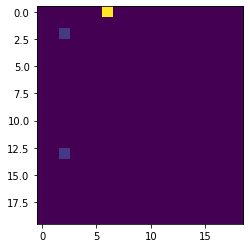

In [108]:
plt.imshow(vectors[:20, 10280:10299])

เปรียบเทียบขนาดเอกสาร กับขนาด matrix จะเห็นว่า row เท่ากัน column = จำนวน vocab

In [59]:
print(len(newsgroups_train.data), vectors.shape)

2034 (2034, 26576)


ดูจำนวนคำใน vocab ที่เก็บใน vectorizer

In [60]:
vocab = np.array(vectorizer.get_feature_names())
vocab.shape

(26576,)

ดูคำใน vocab

In [61]:
vocab[26000:26020]

array(['wick', 'wickard', 'wicked', 'wide', 'widely', 'widengren',
       'widening', 'wider', 'widespread', 'widget', 'widgets', 'widow',
       'width', 'widths', 'wield', 'wien', 'wiener', 'wierd', 'wierdness',
       'wife'], dtype='<U80')

เปรียบเทียบเอกสารจริง กับ Token Counts

In [100]:
print(newsgroups_train.data[1200])




I sure did use version 3.2. It works fine with most software but NOT
with Animator Pro and that one is quite important to me. Pretty
useless program without that thing working IMHO.
So I hope the author can fix that.

/Daniel...





In [98]:
for i, r in enumerate(reversed(sorted(zip(np.squeeze(np.asarray(vectors[1200, :])), vocab)))):
    print(r)
    if i > 20 : break

(1, 'works')
(1, 'working')
(1, 'version')
(1, 'useless')
(1, 'use')
(1, 'thing')
(1, 'sure')
(1, 'software')
(1, 'quite')
(1, 'program')
(1, 'pro')
(1, 'pretty')
(1, 'important')
(1, 'imho')
(1, 'hope')
(1, 'fix')
(1, 'fine')
(1, 'did')
(1, 'daniel')
(1, 'author')
(1, 'animator')
(0, 'zyxel')


# 4. Latent Semantic Analysis (LSA) 

เมื่อเราได้ Matrix ของจำนวนคำศัพท์ที่อยู่ในข้อความทั้งหมดมาแล้ว การนำแต่ละ Vector มาเปรียบเทียบกันตรง ๆ อาจจะไม่ค่อยได้ผล เนื่องจากคำมีหลากหลายมาก ข้อมูลส่วนใหญ่เป็น 0 การเปรียบเทียบ 2 Vector ข้อความที่มีจำนวนคำบางคำใกล้เคียงกัน ไม่สามารถบอกว่าอยู่หมวดหมู่เดียวกันได้

เราจำเป็นต้องนำ Matrix ที่ได้มาผ่านกระบวนการ วิเคราะห์หาความหมายที่ซ่อนอยู่ภายใน Latent Semantic Analysis (LSA) ด้วยวิธีการดังนี้

## 4.1 Singular Value Decomposition (SVD)

SVD เป็นวิธี Factorization ยอดนิยม SVD จะแปลง 1 Matrix ขนาดใหญ่ ออกมาเป็น 3 Matrix ขนาดเล็กกว่า ที่คุณกันแล้วได้เท่ากับ Matrix ต้นทาง

3 Matrix ใหม่ที่ได้ออกมา มีคุณสมบัติพิเศษบางอย่าง ทำให้เราสามารถนำมาใช้งาน วิเคราะห์ข้อความได้ดีขึ้น

หา svd ของ Matrix ต้นฉบับ ชื่อ vectors ออกมาได้เป็น 3 Matrix ชื่อ U, s Vh

เปรียบเทียบ U คือ รายการ [Embedding](https://www.bualabs.com/archives/996/visualization-embedding-deep-learning-model-deep-neural-networks-tensorboard-ep-2/) ของเอกสาร, s คือ ขนาดความสำคัญของ topic ในเอกสาร, Vh คือ รายการ Embedding ของ Topic

In [62]:
%time U, s, Vh = linalg.svd(vectors, full_matrices=False)

CPU times: user 1min 7s, sys: 2.94 s, total: 1min 9s
Wall time: 35.9 s


ดู shape

In [63]:
print(U.shape, s.shape, Vh.shape)

(2034, 2034) (2034,) (2034, 26576)


s จะเป็น Diagonal Matrix แต่มาในรูป Vector

In [64]:
s[:4]

array([433.92698542, 291.51012741, 240.71137677, 220.00048043])

 เราต้องแปลงเอง ดังนี้

In [65]:
np.diag(s[:4])

array([[433.92698542,   0.        ,   0.        ,   0.        ],
       [  0.        , 291.51012741,   0.        ,   0.        ],
       [  0.        ,   0.        , 240.71137677,   0.        ],
       [  0.        ,   0.        ,   0.        , 220.00048043]])

แปลงไปแปลงกลับ

In [109]:
np.diag(np.diag(s[:4]))

array([433.92698542, 291.51012741, 240.71137677, 220.00048043])

พิสูจน์ว่า U, s Vh มาจาก vectors จริง ๆ ด้วยการ จับคูณกัน

In [0]:
b = np.matmul(U, np.diag(s))
x = np.matmul(b, Vh)

เนื่องจากเป็น เลขทศนิยม ทำให้เราเปรียบเทียบ == กันตรง ๆ ไม่ได้ ต้องใช้ np.isclose()

In [68]:
np.all(np.isclose(x, vectors))

True

U เป็น Orthonormal (orthogonal) Matrix หมายถึง คูณกับตัวเอง Transpose แล้วจะได้ Identity Matrix

In [69]:
x = np.matmul(U, U.T)
x[:10, :10]

array([[ 1., -0.,  0., -0.,  0.,  0., -0.,  0., -0.,  0.],
       [-0.,  1.,  0., -0.,  0.,  0., -0., -0., -0.,  0.],
       [ 0.,  0.,  1., -0.,  0., -0.,  0.,  0.,  0., -0.],
       [-0., -0., -0.,  1., -0.,  0., -0., -0., -0., -0.],
       [ 0.,  0.,  0., -0.,  1.,  0.,  0.,  0.,  0., -0.],
       [ 0.,  0., -0.,  0.,  0.,  1., -0.,  0.,  0.,  0.],
       [-0., -0.,  0., -0.,  0., -0.,  1., -0.,  0., -0.],
       [ 0., -0.,  0., -0.,  0.,  0., -0.,  1., -0.,  0.],
       [-0., -0.,  0., -0.,  0.,  0.,  0., -0.,  1.,  0.],
       [ 0.,  0., -0., -0., -0.,  0., -0.,  0.,  0.,  1.]])

Vh ก็เป็น Orthonormal (orthogonal) Matrix เหมือนกัน

In [70]:
x = np.matmul(Vh, Vh.T)
x[:10, :10]

array([[ 1., -0., -0., -0.,  0., -0., -0.,  0., -0., -0.],
       [-0.,  1., -0.,  0., -0., -0.,  0., -0.,  0., -0.],
       [-0., -0.,  1., -0., -0., -0., -0.,  0., -0., -0.],
       [-0.,  0., -0.,  1., -0.,  0.,  0., -0.,  0., -0.],
       [ 0., -0., -0., -0.,  1.,  0.,  0., -0.,  0.,  0.],
       [-0., -0., -0.,  0.,  0.,  1.,  0., -0., -0.,  0.],
       [-0.,  0., -0.,  0.,  0.,  0.,  1., -0., -0.,  0.],
       [ 0., -0.,  0., -0., -0., -0., -0.,  1.,  0., -0.],
       [-0.,  0., -0.,  0.,  0., -0., -0.,  0.,  1.,  0.],
       [-0., -0., -0., -0.,  0.,  0.,  0., -0.,  0.,  1.]])

s คือ Scale Matrix บอกถึงขนาดข้อมูลในแต่ละมิติของ U เมื่อนำมาพล็อตกราฟ จะได้ดังนี้

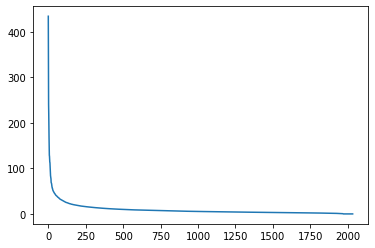

In [71]:
plt.plot(s);

ซูมเข้าไปดู 10 มิติแรก จะเห็นว่าข้อมูลส่วนใหญ่อยู่มิติแรก ๆ เท่านั้น

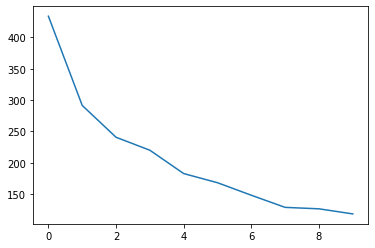

In [72]:
plt.plot(s[:10])

ประกาศฟังก์ชัน แสดงคำศัพท์ใน vocab ที่พบมากที่สุด 8 คำ ในแต่ละ Topic ใน Vh

In [0]:
num_top_words=8

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

แสดงคำศัพท์ใน vocab ที่พบมากที่สุด 8 คำ ใน 10 Topic แรก ดูรายการคำศัพท์ ทำให้เราพอจะเดาได้ว่า ถ้าเอกสารมี Topic นี้มาก น่าจะถูกจำแนกอยู่ใน Category อะไร

In [74]:
show_topics(Vh[:10])

['ditto critus propagandist surname galacticentric kindergarten surreal imaginative',
 'jpeg gif file color quality image jfif format',
 'graphics edu pub mail 128 3d ray ftp',
 'jesus god matthew people atheists atheism does graphics',
 'image data processing analysis software available tools display',
 'god atheists atheism religious believe religion argument true',
 'space nasa lunar mars probe moon missions probes',
 'image probe surface lunar mars probes moon orbit',
 'argument fallacy conclusion example true ad argumentum premises',
 'space larson image theory universe physical nasa material']

## 4.2 Non-negative Matrix Factorization (NMF)

In [0]:
m,n=vectors.shape
d=5  # num topics

In [0]:
clf = decomposition.NMF(n_components=d, random_state=1)

W1 = clf.fit_transform(vectors)
H1 = clf.components_

In [77]:
show_topics(H1)

['jpeg image gif file color images format quality',
 'edu graphics pub mail 128 ray ftp send',
 'space launch satellite nasa commercial satellites year market',
 'jesus god people matthew atheists does atheism said',
 'image data available software processing ftp edu analysis']

# 5. TF-IDF

In [0]:
vectorizer_tfidf = TfidfVectorizer(stop_words='english')
vectors_tfidf = vectorizer_tfidf.fit_transform(newsgroups_train.data) # (documents, vocab)

In [79]:
newsgroups_train.data[10:20]

["a\n\nWhat about positional uncertainties in S-L 1993e?   I assume we know where\nand what Galileo is doing within a few meters.   But without the\nHGA,  don't we have to have some pretty good ideas, of where to look\nbefore imaging?  If the HGA was working,  they could slew around\nin near real time (Less speed of light delay).  But when they were\nimaging toutatis????  didn't someone have to get lucky on a guess to\nfind the first images?   \n\nAlso, I imagine S-L 1993e will be mostly a visual image.  so how will\nthat affect the other imaging missions.  with the LGA,  there is a real\ntight allocation of bandwidth.   It may be premature to hope for answers,\nbut I thought i'd throw it on the floor.",
 "I would like to program Tseng ET4000 to nonstandard 1024x768 mode by\nswitching to standard 1024x768 mode using BIOS and than changing some\ntiming details (0x3D4 registers 0x00-0x1F) but I don't know how to\nselect 36 MHz pixel clock I need. The BIOS function selects 40 MHz.\n\nIs t

In [0]:
W1 = clf.fit_transform(vectors_tfidf)
H1 = clf.components_

In [81]:
show_topics(H1)

['people don think just like objective say morality',
 'graphics thanks files image file program windows know',
 'space nasa launch shuttle orbit moon lunar earth',
 'ico bobbe tek beauchaine bronx manhattan sank queens',
 'god jesus bible believe christian atheism does belief']

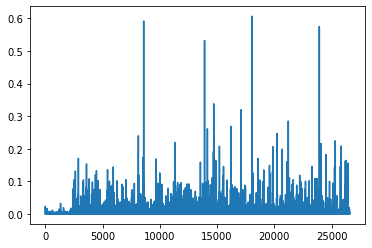

In [82]:
plt.plot(clf.components_[0])

In [83]:
clf.reconstruction_err_

43.712926057952785

# 6. Truncated SVD

In [84]:
%time u, s, v = np.linalg.svd(vectors, full_matrices=False)

CPU times: user 1min 5s, sys: 2.42 s, total: 1min 7s
Wall time: 34.4 s


In [85]:
from sklearn import decomposition
import fbpca

ModuleNotFoundError: ignored

In [0]:
%time u, s, v = decomposition.randomized_svd(vectors, 10)

In [0]:
%time u, s, v = fbpca.pca(vectors, 10)

# Credit

* https://github.com/fastai/course-nlp
* https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html
* https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
* https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.svd.html
* https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
* https://research.fb.com/fast-randomized-svd/